In [429]:
import pandas as pd

In [430]:
weather = pd.read_csv("../data/climat/weather.csv")  # weather data, Reykjavik
pool = pd.read_csv(
    "../data/heimsoknir_i_sundlaugar_heild.csv"
)  # pool visitors, Capital area

# rename columns
pool = pool.rename(
    columns={
        "dagsetning": "date",
        "timi_dags": "time_of_day",
        "sundlaug": "pool",
        "fjoldi_gesta": "visitors",
        "ar": "year",
        "manudur": "month",
        "vikudagur": "weekday",
        "arstid": "season",
        "helgi": "weekend",
    }
)


weather.head()

,average_temperature,max_temperature,min_temperature,rainfall,rain_type,snow_depth,snow_type,sunshine_hours,average_wind_speed,max_wind_speed,gusts,date
0,-0.2,2.4,-7.2,0.1,sn,0,2,0.0,5.1,10.4,16.6,2019-01-01
1,7.7,8.2,1.5,1.1,sl,0,0,0.0,7.8,11.6,19.0,2019-01-02
2,8.0,9.9,6.1,11.9,ri,0,0,0.0,8.0,14.0,22.8,2019-01-03
3,8.8,9.6,5.7,0.8,ri,0,0,0.0,8.3,11.4,18.1,2019-01-04
4,4.0,9.0,0.7,6.1,ri,0,0,0.2,6.1,9.0,15.0,2019-01-05


In [431]:
# add column "date time"
time_span = pool["time_of_day"]  # e.g. 12-13
time_of_day = time_span.map(lambda x: x.split("-")[1])  # e.g. 13
time_of_day = time_of_day.map(
    lambda x: x + ":00" if len(x) == 2 else "0" + x + ":00"
)  # e.g. 13:00
time_of_day = time_of_day.map(
    lambda x: "00:00" if x == "24:00" else x
)  # 24:00 -> 00:00

date = pool["date"]  # e.g. 2019-01-02
date = date.map(lambda x: x.split("-"))  # e.g. ['2019', '01', '02']
date = date.map(lambda x: x[2] + "-" + x[1] + "-" + x[0])  # e.g. 02-01-2019

pool["date_time"] = date + " " + time_of_day
pool["date_time"] = pd.to_datetime(pool["date_time"], format="%d-%m-%Y %H:%M")

pool["unix_time"] = pool["date_time"].map(lambda x: x.timestamp())

pool["weekend"] = pool["date_time"].map(lambda x: x.weekday() >= 5).astype(bool)
pool["weekday"] = pool["date_time"].map(lambda x: x.weekday()).astype(int)
pool["month"] = pool["date_time"].map(lambda x: x.month).astype(int)
pool["year"] = pool["date_time"].map(lambda x: x.year).astype(int)
pool["season"] = pool["date_time"].map(
    lambda x: x.month % 12 // 3 + 1
)  # 1: winter, 2: spring, 3: summer, 4: fall

pool["hour"] = pool["date_time"].map(lambda x: x.hour).astype(int)

pool = pool.drop(columns=["date", "time_of_day"])

pool

,pool,visitors,year,season,month,weekday,weekend,date_time,unix_time,hour
0,Grafarvogslaug,6,2019,3,8,0,False,2019-08-26 20:00:00,1.566850e+09,20
1,Grafarvogslaug,1,2019,3,8,0,False,2019-08-26 21:00:00,1.566853e+09,21
2,Árbæjarlaug,10,2019,3,8,1,False,2019-08-27 09:00:00,1.566896e+09,9
3,Árbæjarlaug,34,2019,3,8,1,False,2019-08-27 10:00:00,1.566900e+09,10
4,Árbæjarlaug,21,2019,3,8,1,False,2019-08-27 11:00:00,1.566904e+09,11
...,...,...,...,...,...,...,...,...,...,...
131389,Sundhöll Reykjavíkur,109,2023,3,6,0,False,2023-06-12 18:00:00,1.686593e+09,18
131390,Sundhöll Reykjavíkur,75,2023,3,6,0,False,2023-06-12 19:00:00,1.686596e+09,19
131391,Sundhöll Reykjavíkur,106,2023,3,6,0,False,2023-06-12 20:00:00,1.686600e+09,20
131392,Sundhöll Reykjavíkur,141,2023,3,6,0,False,2023-06-12 21:00:00,1.686604e+09,21


In [432]:
pool_sorted = pool.sort_values('date_time')
weather_sorted = weather.sort_values('date')

pool_sorted['date_time'] = pd.to_datetime(pool_sorted['date_time'])
weather_sorted['date'] = pd.to_datetime(weather_sorted['date'])

merged_data = pd.merge_asof(pool_sorted, weather_sorted, left_on='date_time', right_on='date', direction='forward')
merged_data = merged_data.ffill()

pool = merged_data.drop(columns=['date'])
pool.head()


,pool,visitors,year,season,month,weekday,weekend,date_time,unix_time,hour,...,max_temperature,min_temperature,rainfall,rain_type,snow_depth,snow_type,sunshine_hours,average_wind_speed,max_wind_speed,gusts
0,Grafarvogslaug,6,2019,3,8,0,False,2019-08-26 20:00:00,1.566850e+09,20,...,12.9,9.4,8.9,ri,0.0,0.0,1.1,3.6,6.7,12.2
1,Grafarvogslaug,1,2019,3,8,0,False,2019-08-26 21:00:00,1.566853e+09,21,...,12.9,9.4,8.9,ri,0.0,0.0,1.1,3.6,6.7,12.2
2,Grafarvogslaug,1,2019,3,8,1,False,2019-08-27 07:00:00,1.566889e+09,7,...,11.7,8.6,1.4,ri,0.0,0.0,0.0,1.9,3.6,6.5
3,Grafarvogslaug,16,2019,3,8,1,False,2019-08-27 08:00:00,1.566893e+09,8,...,11.7,8.6,1.4,ri,0.0,0.0,0.0,1.9,3.6,6.5
4,Grafarvogslaug,13,2019,3,8,1,False,2019-08-27 09:00:00,1.566896e+09,9,...,11.7,8.6,1.4,ri,0.0,0.0,0.0,1.9,3.6,6.5


In [433]:
# Grafarvogslaug
grafarvogslaug = pool[pool["pool"] == "Grafarvogslaug"]

# Árbæjarlaug
arbaejarlaug = pool[pool["pool"] == "Árbæjarlaug"]

# Breiðholtslaug
breidholtslaug = pool[pool["pool"] == "Breiðholtslaug"]

# Sundhöll Reykjavíkur
sundholl_reykjavikur = pool[pool["pool"] == "Sundhöll Reykjavíkur"]

# Vesturbæjarlaug
vesturbaejarlaug = pool[pool["pool"] == "Vesturbæjarlaug"]

# Laugardalslaug
laugardalslaug = pool[pool["pool"] == "Laugardalslaug"]

In [434]:
grafarvogslaug.head()

,pool,visitors,year,season,month,weekday,weekend,date_time,unix_time,hour,...,max_temperature,min_temperature,rainfall,rain_type,snow_depth,snow_type,sunshine_hours,average_wind_speed,max_wind_speed,gusts
0,Grafarvogslaug,6,2019,3,8,0,False,2019-08-26 20:00:00,1.566850e+09,20,...,12.9,9.4,8.9,ri,0.0,0.0,1.1,3.6,6.7,12.2
1,Grafarvogslaug,1,2019,3,8,0,False,2019-08-26 21:00:00,1.566853e+09,21,...,12.9,9.4,8.9,ri,0.0,0.0,1.1,3.6,6.7,12.2
2,Grafarvogslaug,1,2019,3,8,1,False,2019-08-27 07:00:00,1.566889e+09,7,...,11.7,8.6,1.4,ri,0.0,0.0,0.0,1.9,3.6,6.5
3,Grafarvogslaug,16,2019,3,8,1,False,2019-08-27 08:00:00,1.566893e+09,8,...,11.7,8.6,1.4,ri,0.0,0.0,0.0,1.9,3.6,6.5
4,Grafarvogslaug,13,2019,3,8,1,False,2019-08-27 09:00:00,1.566896e+09,9,...,11.7,8.6,1.4,ri,0.0,0.0,0.0,1.9,3.6,6.5


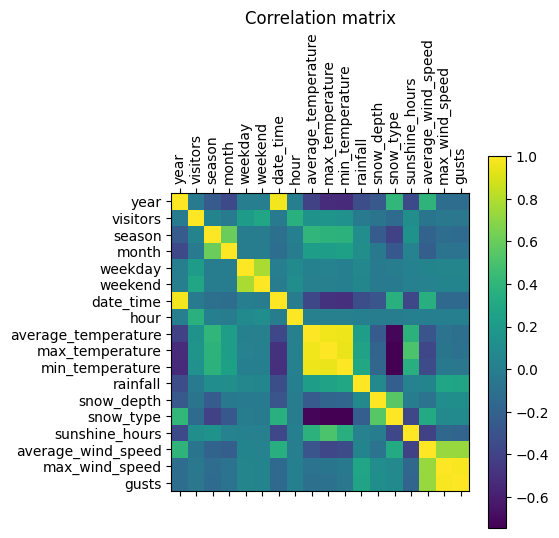

visitors               1.000000
hour                   0.363596
weekend                0.290324
weekday                0.213571
max_temperature        0.157075
average_temperature    0.146555
min_temperature        0.136995
sunshine_hours         0.115148
season                 0.045090
rainfall              -0.018452
year                  -0.022661
month                 -0.030921
date_time             -0.031823
max_wind_speed        -0.047706
gusts                 -0.055279
average_wind_speed    -0.070098
snow_depth            -0.072477
snow_type             -0.132244
Name: visitors, dtype: float64

In [435]:
# correlation matrix
import matplotlib.pyplot as plt

# grafarvogslaug
_grafarvogslaug = grafarvogslaug[
    [
        "year",
        "visitors",
        "season",
        "month",
        "weekday",
        "weekend",
        "date_time",
        "hour",
        "average_temperature",
        "max_temperature",
        "min_temperature",
        "rainfall",
        "snow_depth",
        "snow_type",
        "sunshine_hours",
        "average_wind_speed",
        "max_wind_speed",
        "gusts",
    ]
]

# set everything to numeric
_grafarvogslaug = _grafarvogslaug.apply(pd.to_numeric, errors="coerce")

grafarvogslaug_corr = _grafarvogslaug.corr()


# Plot correlation matrix
plt.matshow(grafarvogslaug_corr)
plt.colorbar()
# Add labels to the plot
plt.xticks(
    range(len(grafarvogslaug_corr.columns)),
    grafarvogslaug_corr.columns,
    rotation="vertical",
)
plt.yticks(range(len(grafarvogslaug_corr.columns)), grafarvogslaug_corr.columns)
plt.title("Correlation matrix")
plt.show()

grafarvogslaug_corr["visitors"].sort_values(ascending=False)

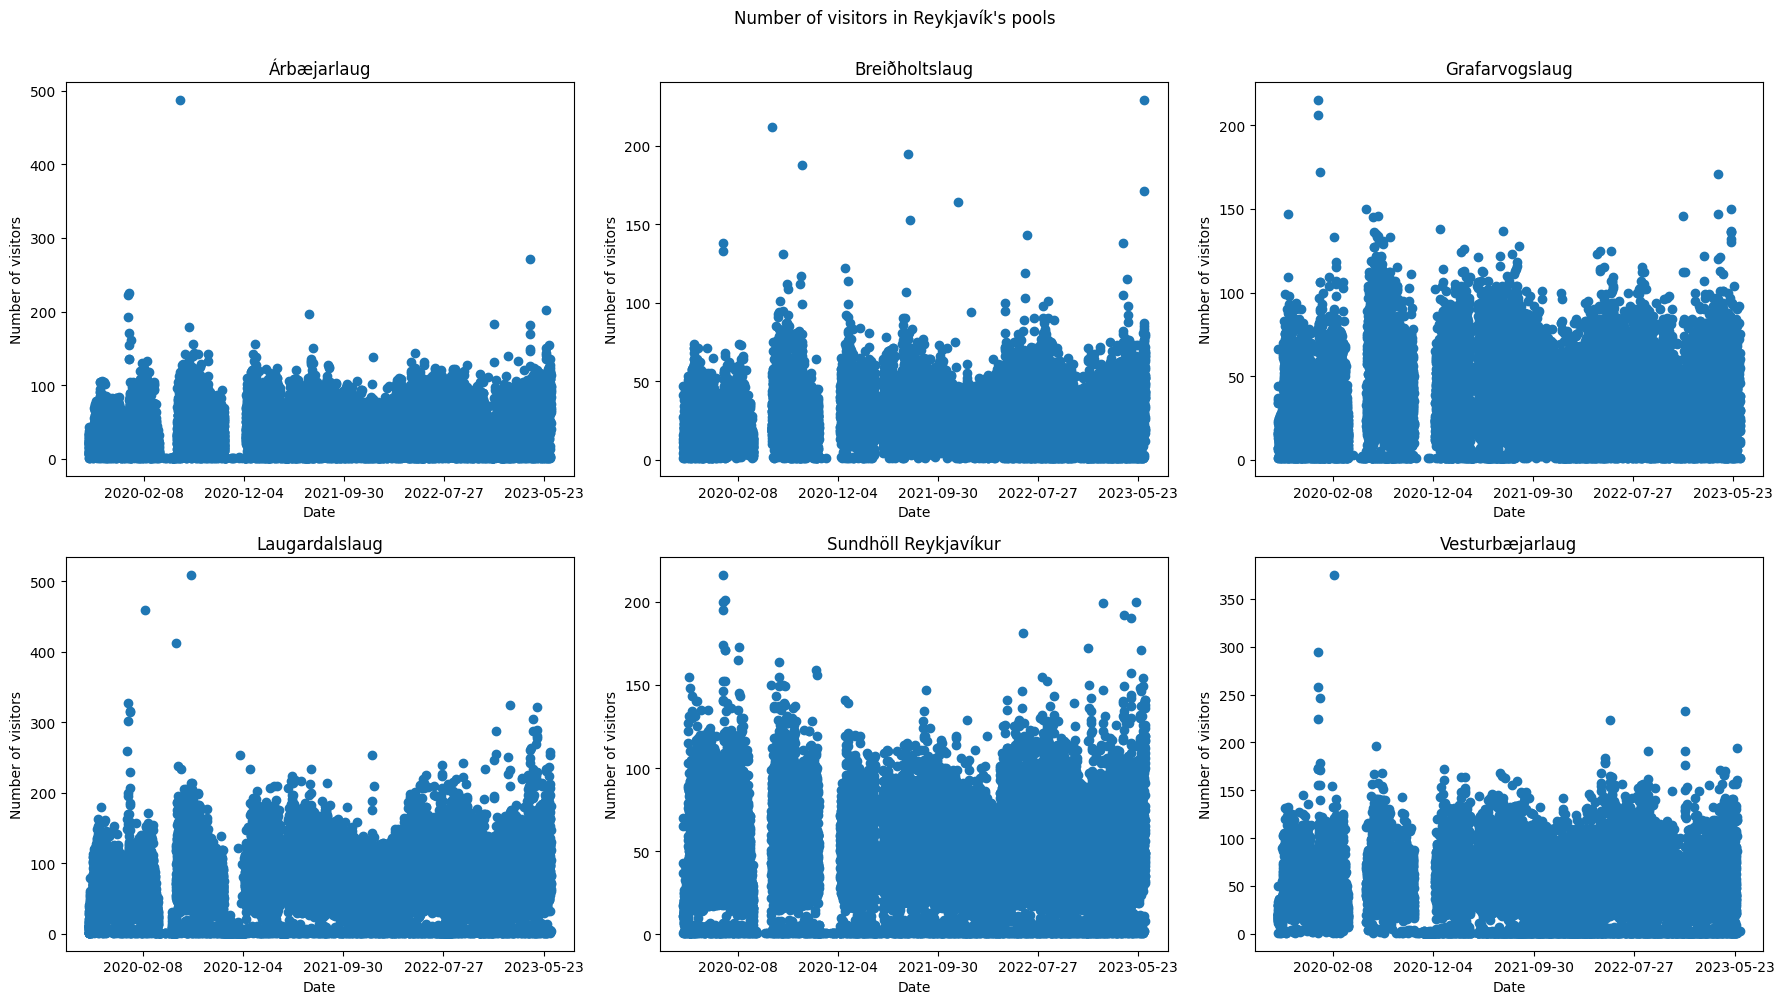

In [436]:
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

fig, axs = plt.subplots(2, 3, figsize=(18, 10))
maxn = MaxNLocator(nbins=6)

axs[0, 0].scatter(arbaejarlaug["date_time"], arbaejarlaug["visitors"])
axs[0, 0].set_xlabel("Date")
axs[0, 0].set_ylabel("Number of visitors")
axs[0, 0].set_title("Árbæjarlaug")
axs[0, 0].xaxis.set_major_locator(maxn)

axs[0, 1].scatter(breidholtslaug["date_time"], breidholtslaug["visitors"])
axs[0, 1].set_xlabel("Date")
axs[0, 1].set_ylabel("Number of visitors")
axs[0, 1].set_title("Breiðholtslaug")
axs[0, 1].xaxis.set_major_locator(maxn)

axs[0, 2].scatter(grafarvogslaug["date_time"], grafarvogslaug["visitors"])
axs[0, 2].set_xlabel("Date")
axs[0, 2].set_ylabel("Number of visitors")
axs[0, 2].set_title("Grafarvogslaug")
axs[0, 2].xaxis.set_major_locator(maxn)

axs[1, 0].scatter(laugardalslaug["date_time"], laugardalslaug["visitors"])
axs[1, 0].set_xlabel("Date")
axs[1, 0].set_ylabel("Number of visitors")
axs[1, 0].set_title("Laugardalslaug")
axs[1, 0].xaxis.set_major_locator(maxn)

axs[1, 1].scatter(sundholl_reykjavikur["date_time"], sundholl_reykjavikur["visitors"])
axs[1, 1].set_xlabel("Date")
axs[1, 1].set_ylabel("Number of visitors")
axs[1, 1].set_title("Sundhöll Reykjavíkur")
axs[1, 1].xaxis.set_major_locator(maxn)

axs[1, 2].scatter(vesturbaejarlaug["date_time"], vesturbaejarlaug["visitors"])
axs[1, 2].set_xlabel("Date")
axs[1, 2].set_ylabel("Number of visitors")
axs[1, 2].set_title("Vesturbæjarlaug")
axs[1, 2].xaxis.set_major_locator(maxn)

fig.suptitle("Number of visitors in Reykjavík's pools", y=1)

plt.tight_layout()  # Adjust the spacing between subplots
plt.show()

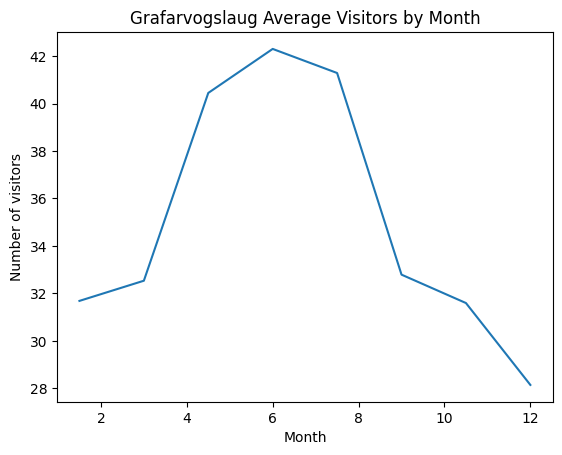

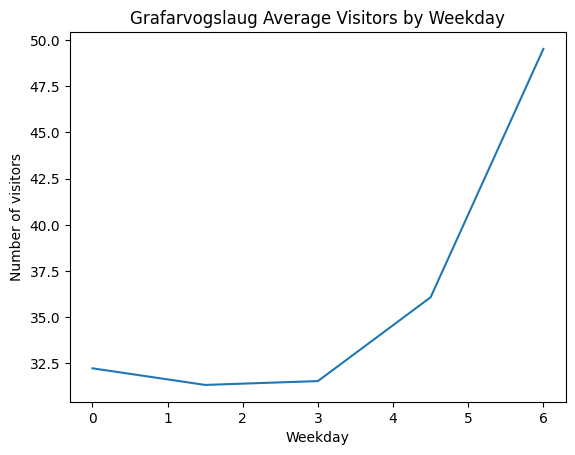

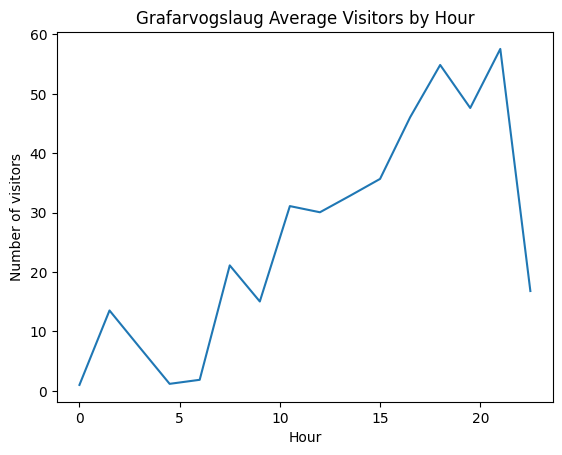

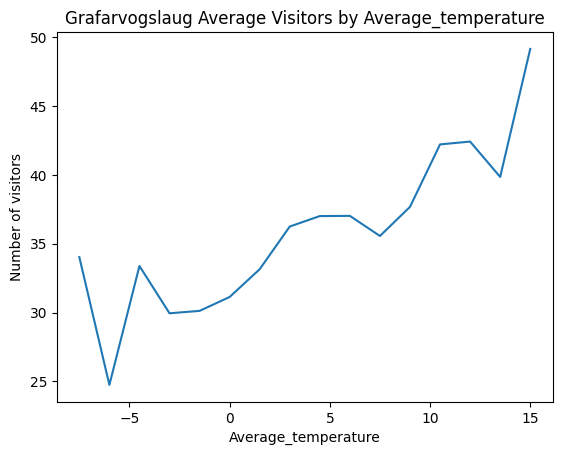

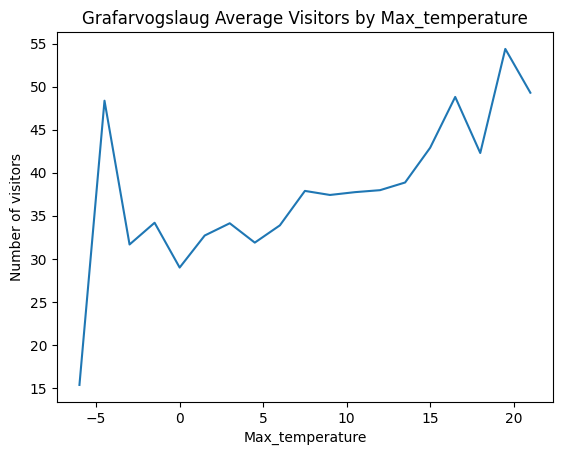

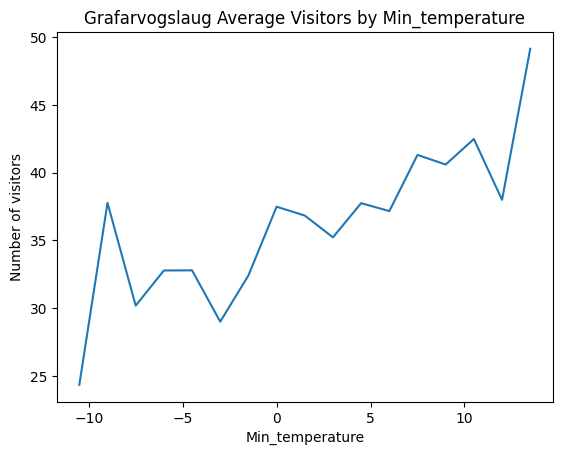

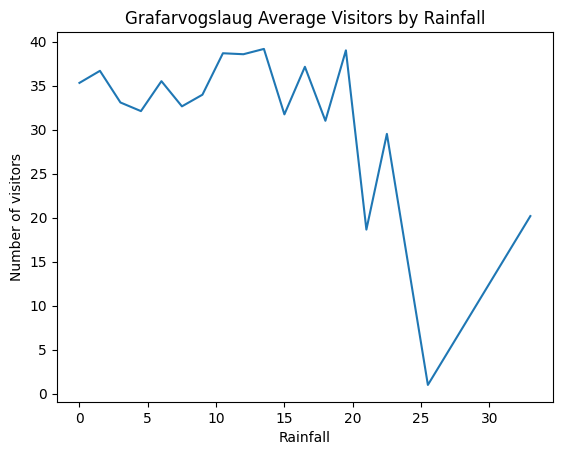

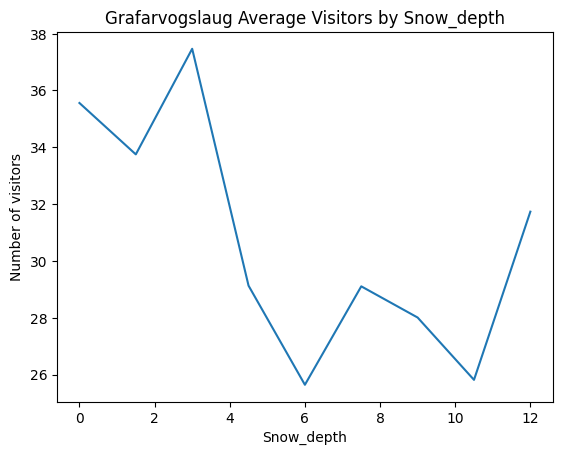

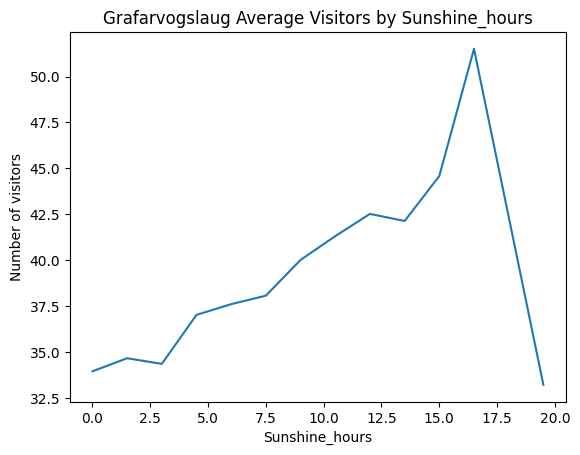

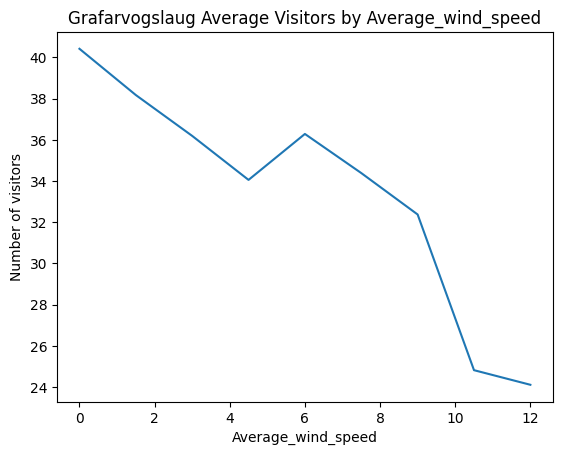

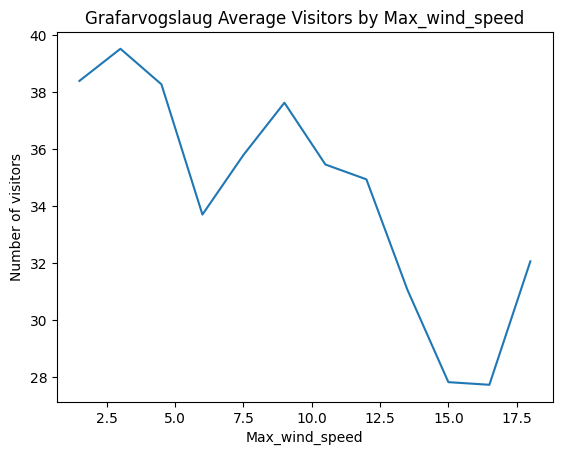

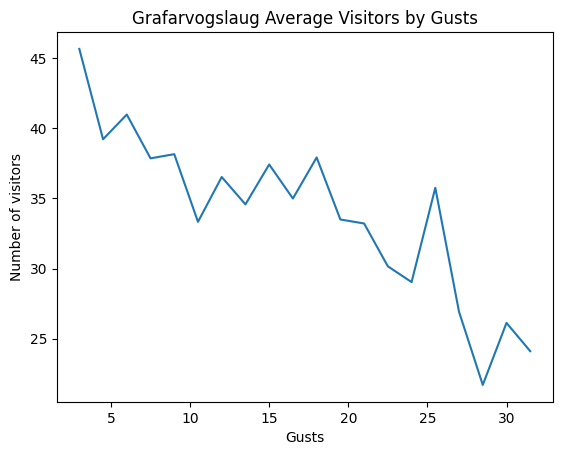

In [437]:


import matplotlib.pyplot as plt

variables = variables = [
    # "year",
        "month",
        "weekday",
        "hour",
        "average_temperature",
        "max_temperature",
        "min_temperature",
        "rainfall",
        "snow_depth",
        "sunshine_hours",
        "average_wind_speed",
        "max_wind_speed",
        "gusts",] 

cleaned_data = grafarvogslaug.dropna(subset=variables)

rounding_factor = 1.5 # 1.5 makes the lines smoother, anything higher than 2 makes the lines too smooth
data_dict = {}

for var in variables:
    rounded_var = cleaned_data[var].map(lambda x: round(x / rounding_factor) * rounding_factor)
    avg_visitors = cleaned_data.groupby(rounded_var)['visitors'].mean()
    data_dict[var] = avg_visitors

df = pd.DataFrame(data_dict)
df['visitors'] = cleaned_data['visitors']

# Create separate plots for each variable
for var in variables:
    x_values = data_dict[var].index.values
    y_values = data_dict[var].values

    plt.figure()  # Create a new plot for each variable
    plt.plot(x_values, y_values)
    plt.xlabel(var.capitalize())
    plt.ylabel('Number of visitors')
    plt.title(f'Grafarvogslaug Average Visitors by {var.capitalize()}')

plt.show()



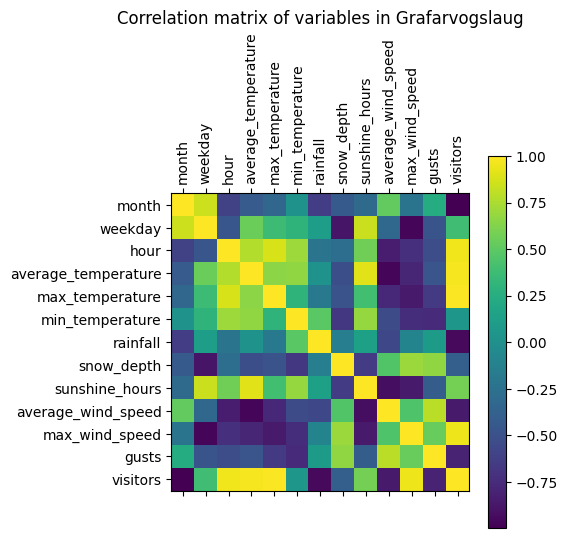

visitors               1.000000
max_temperature        0.986077
average_temperature    0.975072
hour                   0.956600
max_wind_speed         0.947747
sunshine_hours         0.578745
weekday                0.388291
min_temperature        0.054818
snow_depth            -0.393831
gusts                 -0.800147
average_wind_speed    -0.856257
rainfall              -0.949751
month                 -0.999736
Name: visitors, dtype: float64

In [438]:
correlation_matrix = df.corr()

# Plot correlation matrix
plt.matshow(correlation_matrix)
plt.colorbar()
# Add labels to the plot
plt.xticks(
    range(len(correlation_matrix.columns)),
    correlation_matrix.columns,
    rotation="vertical",
)

plt.yticks(range(len(correlation_matrix.columns)), correlation_matrix.columns)
plt.title("Correlation matrix of variables in Grafarvogslaug")
plt.show()


# print the most correlated variables p>0.5 or p<-0.5
correlation_matrix["visitors"].sort_values(ascending=False)

In [439]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from xgboost import XGBRegressor
import numpy as np

variables = [
    "max_temperature",
    "hour",
    "max_wind_speed",
    "sunshine_hours",
    "weekday",
    "snow_depth",
    "gusts",
    "rainfall",
    "year",
    "month",
    "visitors",
]

# Create a subset of the data with the selected variables
mypool = grafarvogslaug[variables].dropna()

# Split the data into features and target variable
X = mypool.drop("visitors", axis=1)
y = mypool["visitors"]

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create an XGBoost regression model
model = XGBRegressor()

# Train the model
model.fit(X_train, y_train)

# Evaluate the model on the test set
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)

print("Root Mean Squared Error (RMSE):", rmse)
print("Validation Score:", model.score(X_test, y_test))

Root Mean Squared Error (RMSE): 12.652492197584557
Validation Score: 0.7067837660903951


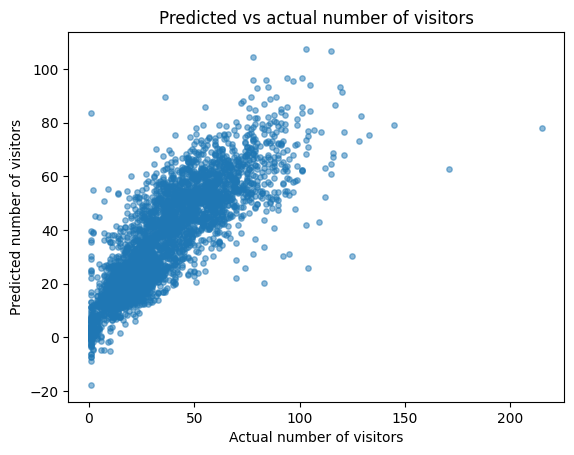

In [440]:
import matplotlib.pyplot as plt

# Make predictions on the test set
y_pred = model.predict(X_test)
# y_pred = scaler.inverse_transform(y_pred.reshape(-1, 1)).flatten()
# y_test = scaler.inverse_transform(y_test.reshape(-1, 1)).flatten()

# Plot the actual vs predicted values
plt.scatter(y_test, y_pred, s=15, alpha=0.5)
plt.xlabel("Actual number of visitors")
plt.ylabel("Predicted number of visitors")
plt.title("Predicted vs actual number of visitors")
plt.show()


# y_pred

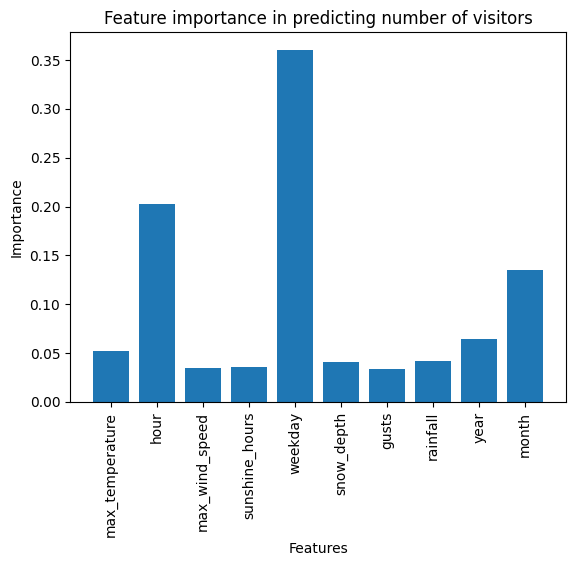

In [441]:
from matplotlib import pyplot as plt

# plot feature importance
plt.bar(range(len(model.feature_importances_)), model.feature_importances_)
plt.xlabel("Features")
plt.ylabel("Importance")
plt.title("Feature importance in predicting number of visitors")
plt.xticks(range(len(model.feature_importances_)), variables[:-1], rotation="vertical")

plt.show()


In [442]:
# from xgboost import XGBRegressor
# from sklearn.ensemble import RandomForestRegressor
# from sklearn.linear_model import LinearRegression
# from sklearn.neural_network import MLPRegressor


# # normalize the data
# from sklearn.preprocessing import StandardScaler

# scaler = StandardScaler()
# X_train = scaler.fit_transform(X_train)
# X_test = scaler.transform(X_test)

# model = MLPRegressor(100, 200, learning_rate="adaptive", early_stopping=True, solver="adam") # worked well for small dataset
# model = MLPRegressor(hidden_layer_sizes=(100, 200, 200, 200, 100), learning_rate="adaptive", early_stopping=True, solver="adam")
# model = XGBRegressor()
# model = RandomForestRegressor()
# model = MLPRegressor()

# model.fit(X_train, y_train)

# model.score(X_test, y_test)

In [443]:
y_pred = model.predict(X_test)
y_pred

array([16.242172, 68.35847 , 36.440567, ..., 16.861568, 30.204966,
       61.416878], dtype=float32)

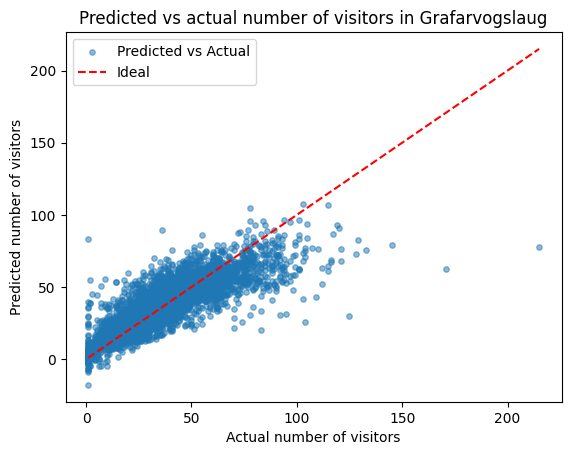

In [444]:
import matplotlib.pyplot as plt

# plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, s=15, alpha=0.5, label='Predicted vs Actual')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'r--', label='Ideal')
plt.xlabel('Actual number of visitors')
plt.ylabel('Predicted number of visitors')
plt.title('Predicted vs actual number of visitors in Grafarvogslaug')
plt.legend()
plt.savefig('./figures/predicted-vs-actual-number-of-visitors-in-grafarvogslaug.png', dpi=300)

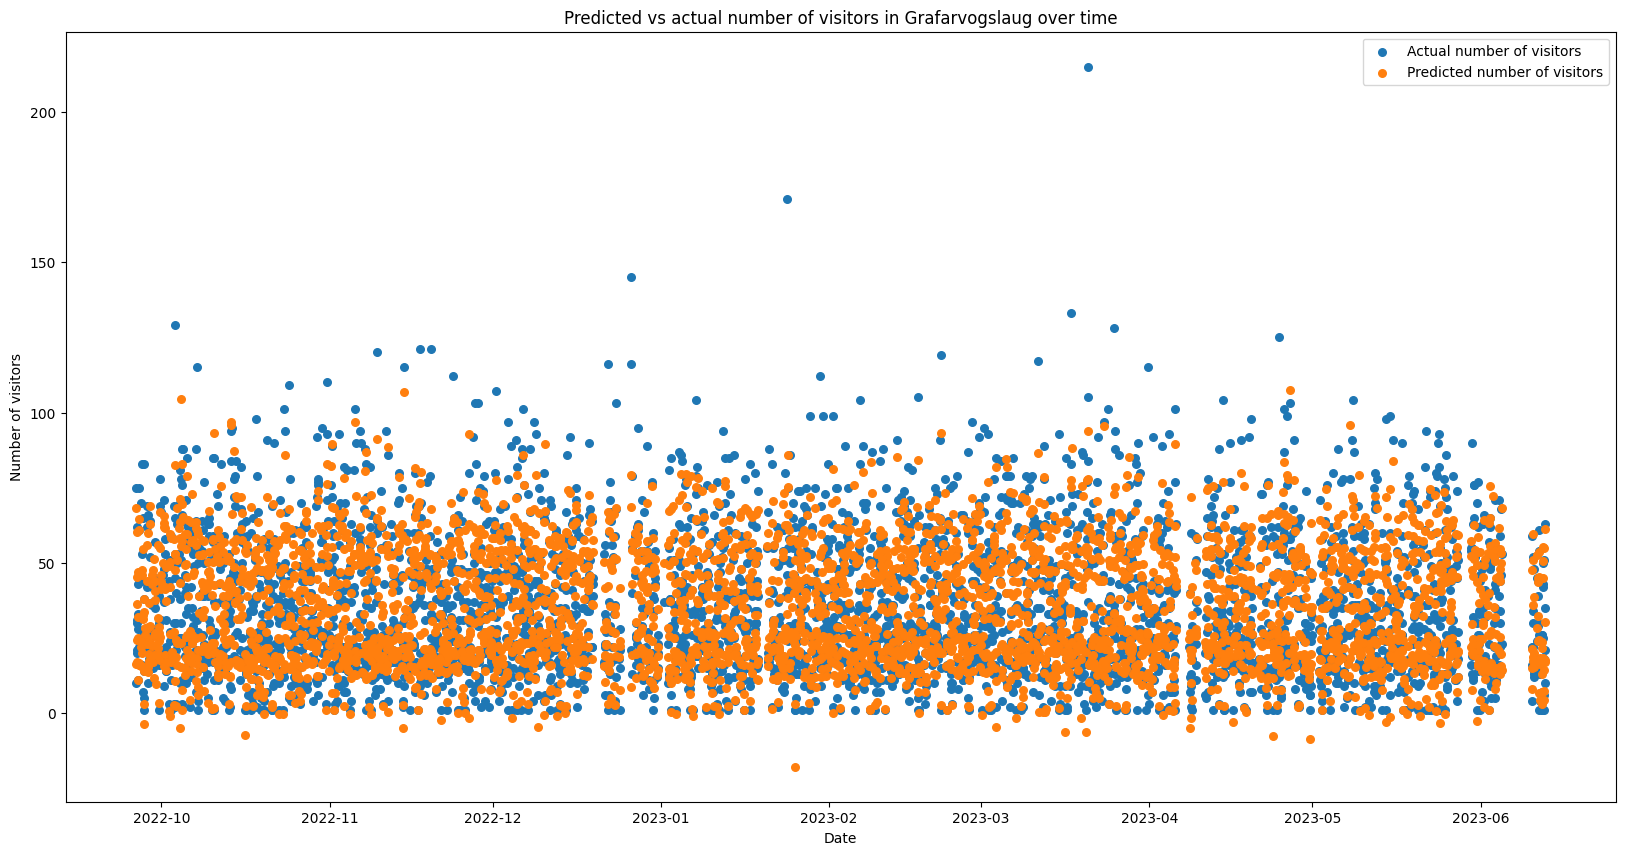

In [445]:
import pandas as pd

# undo the normalization
x_test = scaler.inverse_transform(X_test)
x_test = pd.DataFrame(X_test, columns=variables)
x_test["date_time"] = data["date_time"].iloc[-len(X_test):].values

# plot the data, the prediction and the actual values
plt.figure(figsize=(20, 10))
plt.scatter(x_test["date_time"], y_test, label="Actual number of visitors", s=30)
plt.scatter(x_test["date_time"], y_pred, label="Predicted number of visitors", s=30)
plt.xlabel("Date")
plt.ylabel("Number of visitors")
plt.title("Predicted vs actual number of visitors in Grafarvogslaug over time")
plt.legend()
plt.savefig('./figures/predicted-vs-actual-number-of-visitors-in-grafarvogslaug-over-time.png', dpi=300)

In [446]:
for var in variables:
    plt.scatter(x_test[var], y_test, label="Actual number of visitors", s=30)
    plt.scatter(x_test[var], y_pred, label="Predicted number of visitors", s=30)
    plt.xlabel(var.capitalize())
    plt.ylabel("Number of visitors")
    plt.title(f"Predicted vs actual number of visitors in Grafarvogslaug by {var}")
    plt.legend()
    plt.savefig(f'./figures/predicted-vs-actual-number-of-visitors-in-grafarvogslaug-by-{var}.png', dpi=300)
    plt.clf()

<Figure size 640x480 with 0 Axes>

In [458]:
# make a model for each pool
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from xgboost import XGBRegressor
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from xgboost import XGBRegressor
import numpy as np

variables = [
    "max_temperature",
    "hour",
    "max_wind_speed",
    "sunshine_hours",
    "weekday",
    "snow_depth",
    "gusts",
    "rainfall",
    "year",
    "month",
    "visitors",
]

# Create a subset of the data with the selected variables
pools = [{"name":"Grafarvogslaug", "data":grafarvogslaug}, {"name":"Árbæjarlaug", "data":arbaejarlaug}, {"name":"Breiðholtslaug", "data":breidholtslaug}, {"name":"Sundhöll Reykjavíkur", "data":sundholl_reykjavikur}, {"name":"Vesturbæjarlaug", "data":vesturbaejarlaug}, {"name":"Laugardalslaug", "data":laugardalslaug}]

for i, pool in enumerate(pools):
    pool_name = pool["name"]
    data = pool["data"]
    X = data[variables[:-1]]
    y = data[variables[-1]]

    # Split the data into training and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Create an XGBoost regression model
    model = XGBRegressor(
        n_estimators=1000,
        learning_rate=0.05,
        n_jobs=4,        
    )

    # Train the model
    model.fit(X_train, y_train)

    # Evaluate the model on the test set
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)

    pool["mse"] = mse
    pool["rmse"] = rmse
    pool["validation_score"] = model.score(X_test, y_test)

    import matplotlib.pyplot as plt

    # Make predictions on the test set
    y_pred = model.predict(X_test)

    # Plot the actual vs predicted values
    plt.scatter(y_test, y_pred, s=15, alpha=0.5, label='Predicted vs Actual')
    plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'r--', label='Ideal')
    plt.legend()
    plt.xlabel("Actual number of visitors")
    plt.ylabel("Predicted number of visitors")
    plt.title(f"Predicted vs actual number of visitors in {pool_name}")
    plt.savefig(f'./figures/predicted-vs-actual-number-of-visitors-in-{pool_name}.png', dpi=300)
    plt.clf()


<Figure size 640x480 with 0 Axes>

In [459]:
from tabulate import tabulate

headers = ["Pool name", "MSE", "RMSE", "Validation score"]
rows = [[pool["name"], pool["mse"], pool["rmse"], pool["validation_score"]] for pool in pools]

print(tabulate(rows, headers=headers)
)

Pool name                 MSE     RMSE    Validation score
--------------------  -------  -------  ------------------
Grafarvogslaug        155.132  12.4552            0.715857
Árbæjarlaug           215.119  14.667             0.649318
Breiðholtslaug        101.059  10.0528            0.583312
Sundhöll Reykjavíkur  199.258  14.1159            0.731001
Vesturbæjarlaug       235.211  15.3366            0.730046
Laugardalslaug        473.505  21.7602            0.718292
